# Imports

In [1]:
import numpy as np
import sympy as sp
from sympy import *
import re

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Style changes

In [2]:
rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Statistical Selfcoded functions

In [3]:
# easier formula for gaussian error propagation with addition
def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

# easier formula for gaussian error propagation with multiplication
def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

# Formlae for Gaußen Error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # Für C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #Für C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, enhances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))


# Ergebnisse des Versuchs Supraleiter

Wichtige Anmerkungen zu den Codekonventionen:
- Variablennamen nutzen CamelCase und kürzen ab z.B.: linsenAbstandGegenstand was dem Abstand der Linse von der Gegenstandseite entspricht
- Fehler werden hierbei mit dem Suffix Err im CamelCase gekennzeichnet z.B.: abstandErr entspricht dem Fehler der Abstandsvariable 
- Einheiten stehen kommentiert nach den Einheiten z.B.: x = 3 # mm oder "vMax = 2 # V"

### Verwendetes Equipment
Für den ersten Versuchsteil wurde die Photodiode verwendet. Diese hat zwar, gegenüber der Solarzelle, eine geringere Zeitauflösung, gibt aber dafür ein stärkeres Signal aus. Da Signal kann normalerweise mit dem Transimpedanzverstärker verstärkt werden, da dieser aber nicht funktioniert hat, war das Signal der Solarzelle vom Untergrund zu wenig unterscheidbar.
Der Laser selbst konnte zur Verstärkung des Signals nicht heller gemacht werden, da der Lichtstrahl sonst zu breit wäre und nicht mehr vom Chopper geblockt werden könnte. Dies würde zu einer starken verfälschung des Signals führen.
Es wurde im ersten Versuchsteil das LeCroy Oszilloskop verwendet, da dieses eine deutlich höhere Bandbreite als die Alternative von Rigol. 

Für den zweiten und dritten Versuchsteil wurde die Solarzelle verwendet, da hier der Laser deutlich stärker eingestellt werden kann und daher ein sinnvolles Signal am Oszilloskop erscheint. 
Es wurde das Oszilloskop von Rigol verwendet, da bei der alternative von LeCroy es nicht möglich war, den Delay der beiden Signale anzuzeigen.
Als Funktionsverstärker wurde das neuere Modell von Rigol verwendet, da nur dieser Puls Signale ausgeben konnte.


## 1. Methode: Optischer Chopper

B

### Brennweite der Linse berechnen

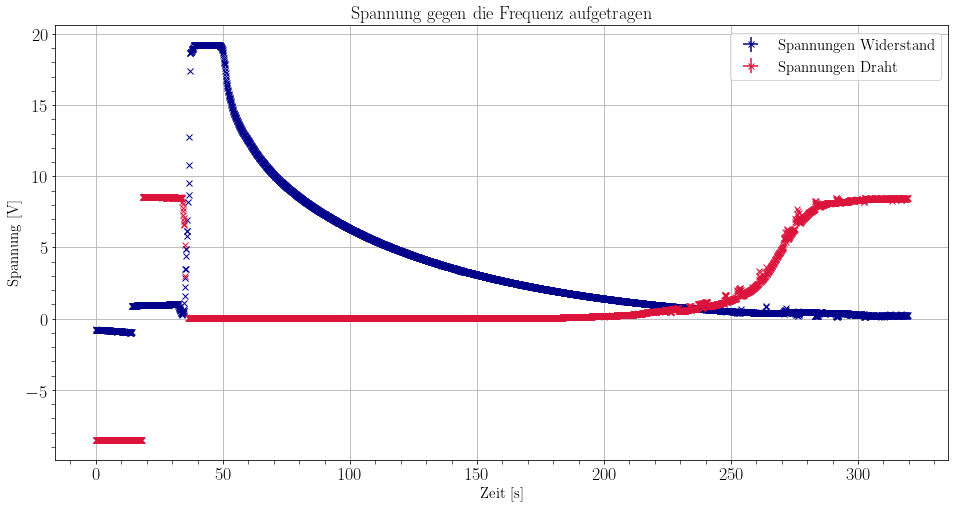

In [12]:
# Daten als Tabelle einlesen quarter goofy ass messung
df = pd.read_csv("quarter goofy ass messung.csv")

# Convert DataFrame columns to NumPy arrays
timeArray = df['Zeit t / s'].to_numpy()
spannungWiderstand = df['Spannung U_A1 / V'].to_numpy() 
spannungDraht = df['Spannung U_B1 / V'].to_numpy()

# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
plt.errorbar(timeArray, spannungWiderstand*100, xerr=0, yerr=0, 
             fmt='.', color='darkblue', label='Spannungen Widerstand', marker='x')

plt.errorbar(timeArray, spannungDraht, xerr=0, yerr=0, 
             fmt='.', color='crimson', label='Spannungen Draht', marker='x')

# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

### Einlesung der Daten
Es wurde nicht der gesamte aufgenommene Datenbereich für die Auswertung genommen, da die Werte für hohe Spannungen einer klar anderen Funktion folgen, als für niedrige, was auch einem visuellen Knick klar ersichtlich ist.

In [14]:
# Einlesen der Daten
messung1HTS = pd.read_csv('Messung_1_HTS.csv')

zeitMessung1HTS = messung1HTS['Zeit t / s'].to_numpy()
spannungUA1Messung1HTS = messung1HTS['Spannung U_A1 / V'].to_numpy()
spannungUB1Messung1HTS = messung1HTS['Spannung U_B1 / V'].to_numpy()


messungWarmKaltHTS = pd.read_csv('Messung_warmkalt_HTS.csv')

zeitMessungWarmKaltHTS = messungWarmKaltHTS['Zeit t / s'].to_numpy()
spannungUA1MessungWarmKaltHTS = messungWarmKaltHTS['Spannung U_A1 / V'].to_numpy()
spannungUB1MessungWarmKaltHTS = messungWarmKaltHTS['Spannung U_B1 / V'].to_numpy()


messungKaltWarmHTS = pd.read_csv('Messung_kaltwarm_HTS.csv')

zeitMessungKaltWarmHTS = messungKaltWarmHTS['Zeit t / s'].to_numpy()
spannungUA1MessungKaltWarmHTS = messungKaltWarmHTS['Spannung U_A1 / V'].to_numpy()
spannungUB1MessungKaltWarmHTS = messungKaltWarmHTS['Spannung U_B1 / V'].to_numpy()


goofyAhMessung = pd.read_csv('goofy ah messung.csv')

zeitgoofyAhMessung = goofyAhMessung['Zeit t / s'].to_numpy()
spannungUA1goofyAhMessung = goofyAhMessung['Spannung U_A1 / V'].to_numpy()
spannungUB1goofyAhMessung = goofyAhMessung['Spannung U_B1 / V'].to_numpy()


goofyAhMessung2 = pd.read_csv('goofy ah messung 2.csv')

zeitgoofyAhMessung2 = goofyAhMessung2['Zeit t / s'].to_numpy()
spannungUA1goofyAhMessung2 = goofyAhMessung2['Spannung U_A1 / V'].to_numpy()
spannungUB1goofyAhMessung2 = goofyAhMessung2['Spannung U_B1 / V'].to_numpy()


semiGoofyAhMessung = pd.read_csv('goofy ah messung.csv')

zeitsemiGoofyAhMessung = semiGoofyAhMessung['Zeit t / s'].to_numpy()
spannungUA1semiGoofyAhMessung = semiGoofyAhMessung['Spannung U_A1 / V'].to_numpy()
spannungUB1semiGoofyAhMessung = semiGoofyAhMessung['Spannung U_B1 / V'].to_numpy()


semiGoofyAhMessung2 = pd.read_csv('goofy ah messung 2.csv')

zeitsemiGoofyAhMessung2 = semiGoofyAhMessung2['Zeit t / s'].to_numpy()
spannungUA1semiGoofyAhMessung2 = semiGoofyAhMessung2['Spannung U_A1 / V'].to_numpy()
spannungUB1semiGoofyAhMessung2 = semiGoofyAhMessung2['Spannung U_B1 / V'].to_numpy()


quarterGoofyAhMessung = pd.read_csv('goofy ah messung 2.csv')

zeitquarterGoofyAhMessung2 = quarterGoofyAhMessung['Zeit t / s'].to_numpy()
spannungUA1quarterGoofyAhMessung2 = quarterGoofyAhMessung['Spannung U_A1 / V'].to_numpy()
spannungUB1quarterGoofyAhMessung2 = quarterGoofyAhMessung['Spannung U_B1 / V'].to_numpy()

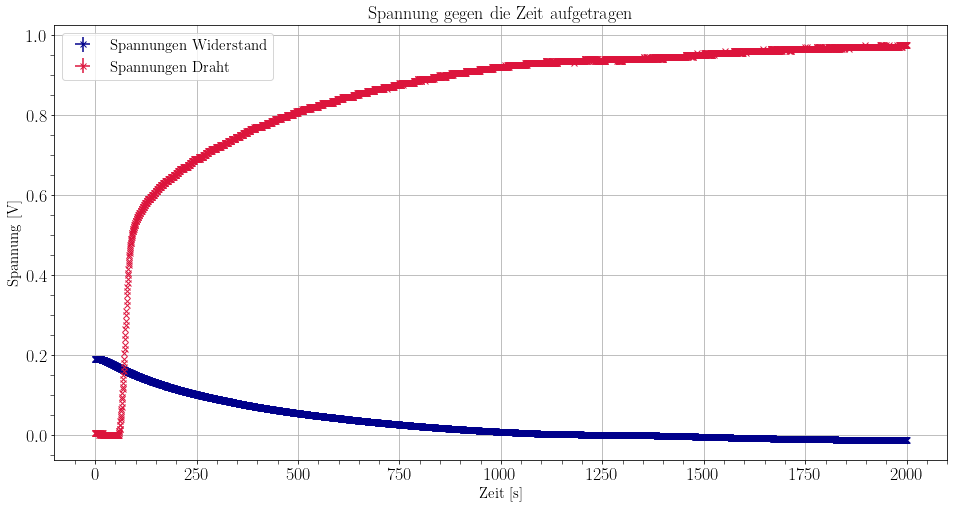

In [19]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
plt.errorbar(zeitMessungKaltWarmHTS, spannungUA1MessungKaltWarmHTS, xerr=0, yerr=0, 
             fmt='.', color='darkblue', label='Spannungen Widerstand', marker='x')

plt.errorbar(zeitMessungKaltWarmHTS, spannungUB1MessungKaltWarmHTS, xerr=0, yerr=0, 
             fmt='.', color='crimson', label='Spannungen Draht', marker='x')

# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()

In [ ]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
plt.errorbar(zeitMessungKaltWarmHTS, spannungUA1MessungKaltWarmHTS, xerr=0, yerr=0, 
             fmt='.', color='darkblue', label='Spannungen Widerstand', marker='x')

plt.errorbar(zeitMessungKaltWarmHTS, spannungUB1MessungKaltWarmHTS, xerr=0, yerr=0, 
             fmt='.', color='crimson', label='Spannungen Draht', marker='x')

# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()

### Fit berechnen

In [6]:
frequenzBereich = np.arange(0, 60001, 1)

# Cosinusfunktion 
def myCos(x, f, p):
    return 3359420*np.cos(f*x+p) + 3359420

# Fitfunktion
def fitCos(p0, x, y):
    fit = curve_fit(myCos, x, y, p0=p0, maxfev = 10000000)
    data_fit = myCos(frequenzBereich, *fit[0])
    minPoint = np.array([data_fit.argmin(), min(data_fit)]) 
    return data_fit, minPoint, fit 

# Anfangswerte für den fit (geraten)
freqGuess = 1/(340000*pc.pi)
phaseGuess = pi/1.0035
p0 = np.array([freqGuess, phaseGuess] )

# Berechnen der gefitteten Werte
fitWerte, minPoint, fit = fitCos(p0,frequenzen,spannungen)

fitErr = np.sqrt(np.diag(fit[0]))

minPointErr = minPoint[0]*fitErr[0][0]+fitErr[1][1]

lichtgeschwindigkeit, lichtgeschwindigkeitErr = MultiplikationMitFehler(minPoint[0], minPointErr, LichtLaufstrecke1, LichtLaufstrecke1Err)

### Anzeigen der Daten

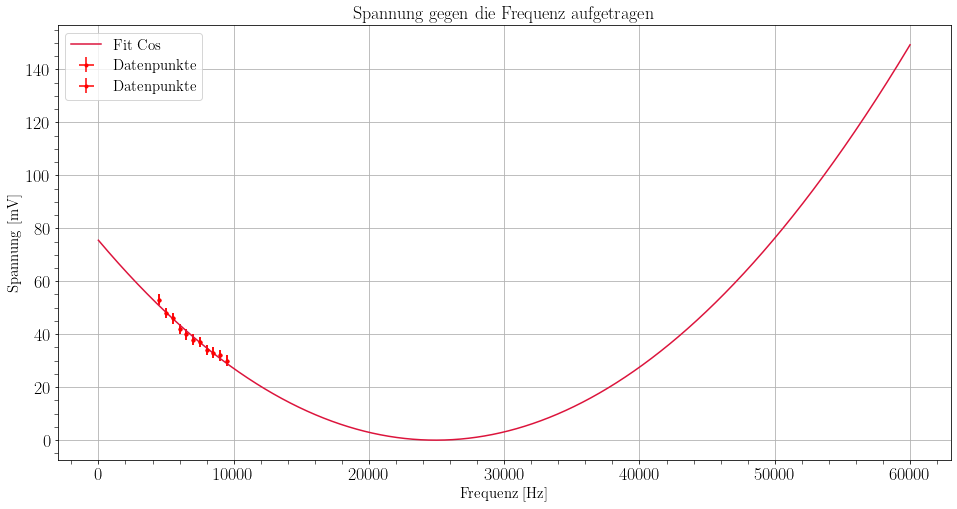

Minimalpunkt liegt bei: $24935 \pm 15$ [Hz]
  
   Dies entspricht einer Lichtgeschwindigkeit von: $27.9 \pm 0.5$ [km/s]

In [7]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen, spannungen, xerr=frequenzenErr, yerr=spannungenErr, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen, spannungen, xerr=frequenzenErr, yerr=spannungenErr, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Angepasste Cosinusfunktion aufzeichnen
plt.plot(frequenzBereich, fitWerte, color='crimson', label='Fit Cos',marker=None)

# labels und legend
plt.xlabel(r'Frequenz [Hz]')
plt.ylabel(r'Spannung [mV]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Minimalpunkt liegt bei: ${minPoint[0]:.0f} \pm {minPointErr:.0f}$ [Hz]\n  
   Dies entspricht einer Lichtgeschwindigkeit von: ${lichtgeschwindigkeit/1000:.1f} \pm {lichtgeschwindigkeitErr/1000:.1f}$ [km/s]""")

### Dateneingabe der zweiten Messreihe Chopper

In [8]:
# Gemessene Spannungen

# Vollständige Messung
# spannungen2 = np.array([600, 395, 285, 224, 184, 161, 143, 129, 116, 108, 95, 72, 66, 62, 58, 55, 52, 49, 47, 45])  # mV

# Ausgewählter Bereich
spannungen2 = np.array([72, 66, 62, 58, 55, 52, 49, 47, 45])  # mV

# Fehler der Spannungen (durch Variation am Oszilloskop geschätzt)

# Vollständige Messung
#spannungen2Err = np.array([5,4,4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # mV

# Im ausgewählten Bereich
spannungen2Err = 1 # mV

# Dazugehörige Frequenzen
frequenzen2 = np.arange(12, 21, 1)*1e3   # Hz

# Fehler der Frequenzen
frequenzen2Err = 20 # Hz

### Fit berechnen

In [9]:
# Frequenzbereich festlegen
frequenzBereich2 = np.arange(0, 60001, 1)

# Cosinusfunktion 
def myCos(x, f, p):
    return 3359420*np.cos(f*x+p) + 3359420


# Fitfunktion
def fitCos(p0, x, y):
    fit = curve_fit(myCos, x, y, p0=p0, maxfev = 10000000)
    data_fit = myCos(frequenzBereich, *fit[0])
    minPoint = np.array([data_fit.argmin(), min(data_fit)]) 
    return data_fit, minPoint, fit

# Anfangswerte für den fit (geraten)
freqGuess = 2e-07
ampGuess = 3000000
phaseGuess = 3.1325
offsetGuess = 3000050
p0 = np.array([freqGuess, phaseGuess])

# Berechnen der gefitteten Werte
fitWerte2, minPoint2, fit2 = fitCos(p0,frequenzen2,spannungen2)

fitErr2 = np.sqrt(np.diag(fit2[0]))

minPointErr2 = minPoint2[0]*fitErr2[0][0]+fitErr2[1][1]

lichtgeschwindigkeit2, lichtgeschwindigkeitErr2 = MultiplikationMitFehler(minPoint2[0], minPointErr2, LichtLaufstrecke1, LichtLaufstrecke1Err)

### Anzeigen der Daten

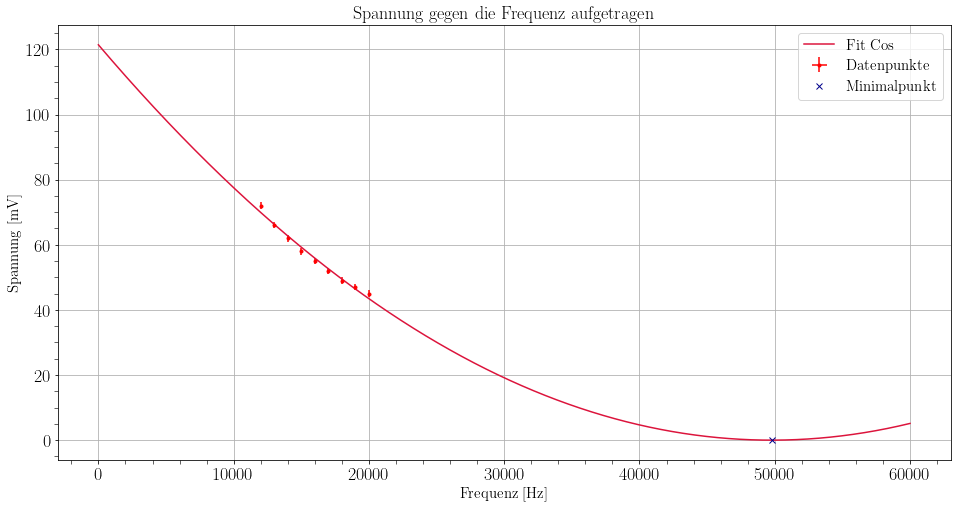

Minimalpunkt liegt bei: $49766 \pm 22$ [Hz]
  
   Dies entspricht einer Lichtgeschwindigkeit von: $55.7 \pm 1.0$ [km/s]

In [10]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))  

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen2, spannungen2, xerr=frequenzen2Err, yerr=spannungen2Err, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Angepasste Cosinusfunktion aufzeichnen
plt.plot(frequenzBereich2, fitWerte2, color='crimson', label='Fit Cos',marker=None)

# Minimalpunkt
plt.errorbar(minPoint2[0], minPoint2[1], color='darkblue', label='Minimalpunkt', fmt='x')

# labels und legend
plt.xlabel(r'Frequenz [Hz]')
plt.ylabel(r'Spannung [mV]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Minimalpunkt liegt bei: ${minPoint2[0]:.0f} \pm {minPointErr2:.0f}$ [Hz]\n  
   Dies entspricht einer Lichtgeschwindigkeit von: ${lichtgeschwindigkeit2/1000:.1f} \pm {lichtgeschwindigkeitErr2/1000:.1f}$ [km/s]""")

## 2. Methode Funktionsgenerator
Die gesamte Strecke, welche das Licht zurücklegt wird entsprechend der Skizze mit der Formel

$$L = A + B + C + \sqrt{F^2+C^2}$$

bestimmt. Für den Fehler haben wir auf jede Messung einen Wert von $\Delta = 0.002$m geschätzt, bei diesem Werthandeölt es sich um einen statistischen Fehler, da er sich nicht nach der Skalenauflösung des Messinstruments richtet (das Messinstrument war ein Bandmaß mit einer Skalenauflösung von 1mm), sondern nach der Ungenauigkeit der vermessenden Person. Mittels der Gaußschen Fehlerfortpflanzung ergibt sich aus diesem Fehler dann ein Fehler für die gesamte Länge von 

$$\Delta L=\sqrt{0.006\text{m}+0.002\text{m}(F^{2}+C^{2})^{-\frac{1}{2}}(F+C)}$$

Der Fehler auf den Delay wurde mit $\Delta Delay = 0.2$ns geschätzt.

In [11]:
# Funktion zum Berechnen der Lichtlaufstrecke
def bestimmungLichtLaufstrecke(C):
    return np.sqrt(F**2+C**2) + A + B + C

# Funktion zum Berechnen des Fehlers auf die Lichtlaufstrecke mittels Gaußscher Fehlerfortpflanzung
def bestimmungLichtLaufstreckeErr(C): 
    return np.sqrt(0.006+0.002*(F**2+C**2)**(-1/2)*(F+C))

# Längen des Aufbaus:
A,B,F = 0.763, 0.750, 0.065                                 # m
MessungenC = np.array([0.74,0.64,0.54,0.44,0.34,0.24,0.14]) # m
StreckenmessungErr = 0.002                                  # m

# Gemessene Delays mit Average, min und max, abgelesen vom Oszilloskop
delayAverage = np.array([10.2,9.9,9.7,9.4,9,8.3,7.6]) * 10**-9 # s
delayMin = np.array([9.6,9.6,9.3,9.3,8.8,7.2,7.0]) * 10**-9    # s
delayMax = np.array([10.6,10.2,9.9,9.9,9.6,10.9,9.4]) * 10**-9 # s
delayErr = 0.2 * 10**-9                                        # s

# Berechnen Gesamt Länge und Fehler
LichtLaufstrecke2 = bestimmungLichtLaufstrecke(MessungenC)
LichtLaufstrecke2Err = bestimmungLichtLaufstreckeErr(MessungenC)

### Lineare Regression berechnen

In [29]:
# Lineare Regression bestimmen
bTeil2 = bestB(delayAverage,LichtLaufstrecke2)
mTeil2 = bestM(delayAverage,LichtLaufstrecke2)

# Fehler der Linearen Regression bestimmen
bTeil2Err = stuB(delayAverage,LichtLaufstrecke2)
mTeil2Err = stuM(delayAverage,LichtLaufstrecke2)

zeichenBereichTeil2 = np.linspace(1.65, 3.1, 100)

### Plotten der Daten und Lineare Regression

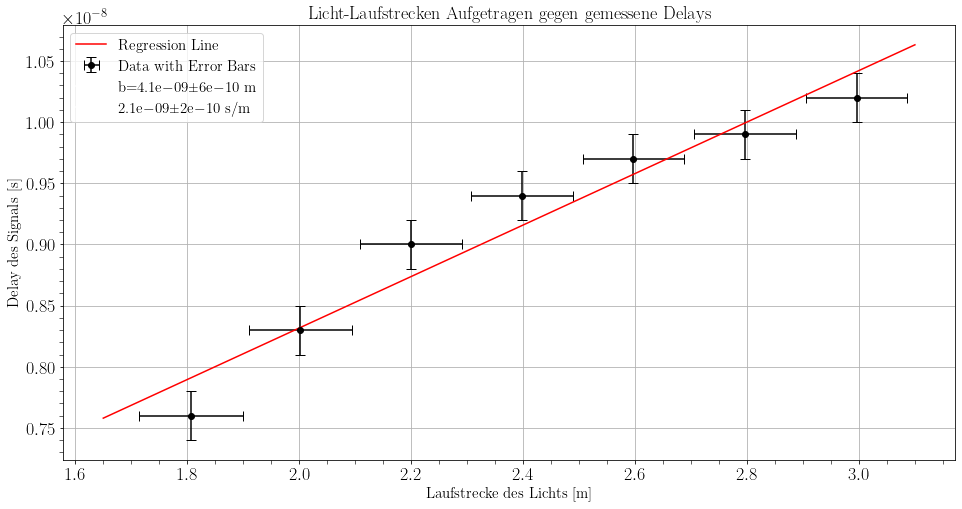

Für den Fit ergeben sich die Werte 

$b = 4.1e-09 \pm 6e-10$ s 

$m = 2.1e-09 \pm 2e-10$ s/m

Die gemessene Lichtgeschwindigkeit ergibt sich also aus dem Inversen der Steigung der Geraden: 

$c_{gemessen} = 4.8e+08 \pm 5e+07$ m/s

In [30]:
# Plotten der Daten und Lineare Regression
bTeil2 = bestB(LichtLaufstrecke2,delayAverage)
mTeil2 = bestM(LichtLaufstrecke2,delayAverage)

#Fehler der Linearen Regression bestimmen
bTeil2Err = stuB(LichtLaufstrecke2,delayAverage)
mTeil2Err = stuM(LichtLaufstrecke2,delayAverage)

#gemessene lichtgeschwindigkeit
LichtgeschwindigkeitGemessen2 = DivisionMitFehler(1, 0,mTeil2, mTeil2Err)[0]
LichtgeschwindigkeitGemessen2Err = DivisionMitFehler(1, 0,mTeil2, mTeil2Err)[1]

# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Zeichnen der Datenpunkte in schwarz
plt.errorbar(LichtLaufstrecke2, delayAverage, xerr=LichtLaufstrecke2Err,
             yerr=delayErr, fmt='o',capsize=5, label='Data with Error Bars', color='black')

# Zeichnen der linearen Ausgleichsgerade in rot
plt.plot(zeichenBereichTeil2, mTeil2 * zeichenBereichTeil2 + bTeil2, color='red', label='Regression Line')

#b pm und m pm in die Legende einfügen
plt.errorbar(2.6,0.9*10**-8,markersize='0',label = "b=4.1e−09±6e−10 m", color="white")
plt.errorbar(2.6,0.9*10**-8,markersize='0',label = "2.1e−09±2e−10 s/m ", color="white")


# Achsenbeschriftungen
plt.ylabel(r'Delay des Signals [s]')
plt.xlabel(r'Laufstrecke des Lichts [m]')
plt.title("Licht-Laufstrecken Aufgetragen gegen gemessene Delays")

plt.legend()
plt.show()


# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Für den Fit ergeben sich die Werte \n
$b = {bTeil2:.1e} \pm {bTeil2Err:.0e}$ s \n
$m = {mTeil2:.1e} \pm {mTeil2Err:.0e}$ s/m\n
Die gemessene Lichtgeschwindigkeit ergibt sich also aus dem Inversen der Steigung der Geraden: \n
$c_{{gemessen}} = {LichtgeschwindigkeitGemessen2:.1e} \pm {LichtgeschwindigkeitGemessen2Err:.0e}$ m/s""")

## 3. Pulslaser
Statt des einfachen Laserpointers wurde nun der Pulslaser angeschlossen, welcher mittels des Funktionsgenerator gesteuert wurde. 
Diesmal wurde nur der abstand D variiert. Es ergibt sich also für die Lichtlauflänge

$$L=A+B+C+D$$

Für den fehler ergibt sich 

$$\Delta L = \sqrt{4\cdot0.002\text{m}}=0.004\text{m}$$

### Daten eingeben

In [31]:
# Lichtlaufstrecke
A, B, C = 0.565, 0.782, 0.815
MessungenD = np.array([60,50,40,30,20,10])*0.01
fehlerStreckenmessung = 0.002

LichtLaufstrecke3 = MessungenD + A + B + C
LichtLaufstrecke3Err = np.sqrt(4*0.002)

# gemessene Delays mit Fehler
MessungDelay3 = np.array([12,11,10,9,7.6,5]) * 10**-9
MessungDelay3Err = np.array([1,1,1,1,0.5,2]) * 10**-9 

### Fit berechnen

In [32]:
# Bestimmung der Fitparameter
bTeil3 = bestB(MessungDelay3,LichtLaufstrecke3)
mTeil3 = bestM(MessungDelay3,LichtLaufstrecke3)

# Bestimmung von Fehler auf Fit parameter
bTeil3Err = stuB(MessungDelay3,LichtLaufstrecke3)
mTeil3Err = stuM(MessungDelay3,LichtLaufstrecke3)

# Definieren des Zeichenbereichs
zeichenBereichTeil3 = np.linspace(2.1, 2.85, 100)

### Daten Plotten mit Errorbars

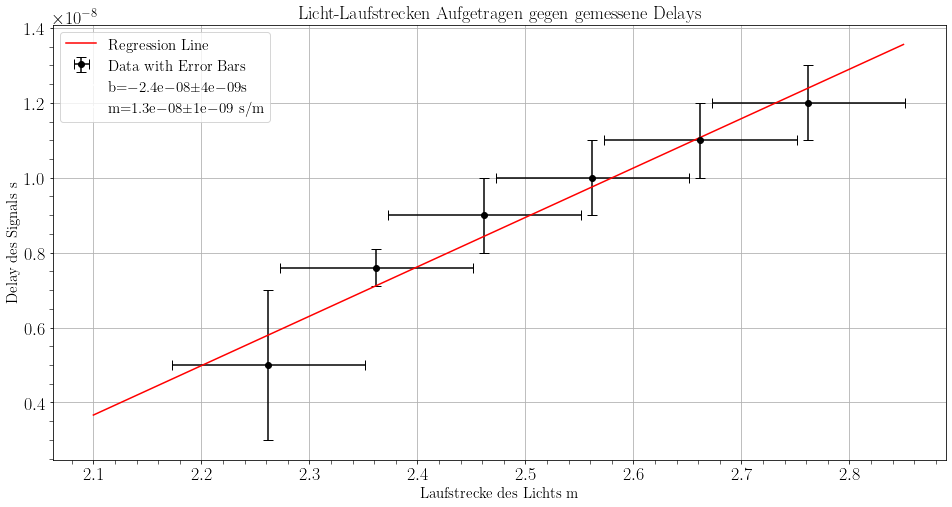

Für den Fit ergeben sich die Werte 

$b = -2.4e-08 \pm 4e-09$ s 

$m = 1.3e-08 \pm 1e-09$ s/m 

Die gemessene Lichtgeschwindigkeit ergibt sich also aus dem Inversen der Steigung der Geraden: 

$c_{gemessen} = 7.6e+07 \pm 8e+06$ m/s

In [33]:
# Daten Plotten mit Errorbars

#Bestimmung der Fitparameter
bTeil3 = bestB(LichtLaufstrecke3,MessungDelay3)
mTeil3 = bestM(LichtLaufstrecke3,MessungDelay3)

#Bestimmung von Fehler auf Fit parameter
bTeil3Err = stuB(LichtLaufstrecke3,MessungDelay3)
mTeil3Err = stuM(LichtLaufstrecke3,MessungDelay3)

#gemessene lichtgeschwindigkeit
LichtgeschwindigkeitGemessen3 = DivisionMitFehler(1, 0,mTeil3, mTeil3Err)[0]
LichtgeschwindigkeitGemessen3Err = DivisionMitFehler(1, 0,mTeil3, mTeil3Err)[1]

# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Datenpunkte einzeichnen
plt.errorbar(LichtLaufstrecke3,MessungDelay3, xerr=LichtLaufstrecke3Err, yerr=MessungDelay3Err, capsize=5,
             fmt='o', label='Data with Error Bars', color='black')

# Ausgleichsgerade einzeichnen
plt.plot(zeichenBereichTeil3, mTeil3 * zeichenBereichTeil3 + bTeil3, color='red', label='Regression Line')

#b pm und m pm in die Legende einfügen
plt.errorbar(2.6,0.9*10**-8,markersize='0',label = "b=−2.4e−08±4e−09s ", color="white")
plt.errorbar(2.6,0.9*10**-8,markersize='0',label = "m=1.3e−08±1e−09 s/m", color="white")

# Achsenbeschriftungen
plt.ylabel(r'Delay des Signals s')
plt.xlabel(r'Laufstrecke des Lichts m')
plt.title("Licht-Laufstrecken Aufgetragen gegen gemessene Delays")

plt.legend()
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Für den Fit ergeben sich die Werte \n
$b = {bTeil3:.1e} \pm {bTeil3Err:.0e}$ s \n
$m = {mTeil3:.1e} \pm {mTeil3Err:.0e}$ s/m \n
Die gemessene Lichtgeschwindigkeit ergibt sich also aus dem Inversen der Steigung der Geraden: \n
$c_{{gemessen}} = {LichtgeschwindigkeitGemessen3:.1e} \pm {LichtgeschwindigkeitGemessen3Err:.0e}$ m/s""")

### Berechnung t-Werte

In [17]:
t1 = abs((lichtgeschwindigkeit-pc.c)/lichtgeschwindigkeitErr)
tMin = abs(lichtgeschwindigkeitMin-pc.c)/lichtgeschwindigkeitMinErr
t2 = abs((lichtgeschwindigkeit2-pc.c)/lichtgeschwindigkeitErr2)
t3 = abs((mTeil2-pc.c)/mTeil2Err)
t4 = abs((mTeil3-pc.c)/mTeil3Err)

print(tMin)

706671.2805280527


# Diskussion
Es wurde für die 1. Methode mit dem Optischer Chopper mithilfe zweier Messreihen die Lichtgeschwindigkeit berechnen: dabei ergaben sich die folgenden Werte:
$$
 c_1 = 27.9\pm 0.5 \times 10^3 \times 10^3 \frac{\text{m}}{\text{s}} \quad  
 c_2 = 55.7\pm 1.0 \times 10^3 \frac{\text{m}}{\text{s}}
$$
Wenn wir dies mit dem Literaturwert der Lichtgeschwindigkeit $\left(299 792 458 \frac{\text{m}}{\text{s}}\right)$ mithilfe eines t-Tests vergleichen erhalten wir t-Werte von:
$$
 t_1 = 5.8\times10^5 \quad  
 t_2 = 2.9\times10^5
$$
Diese Verträglichkeiten sind nicht im Bereich t<2, womit der ermittelte Wert und der Literaturwert nicht miteinander verträglich sind. Die Messwerte ergeben eine Lichtgeschwindigkeit, die nicht annähernd richtig ist. Als Untergrenze der Lichtgeschwindigkeit wurde folgender Wert ermittelt:
$$
    c_\text{ug} = 22.5 \pm 0.4 \times 10^3 \frac{\text{m}}{\text{s}}
$$
Für die 2. Messmethode mit dem Funktiongenerator (Durch Subtext 'fg' gekennzeichnet) erhielten wir als Lichtgeschwindigkeit un den dazugeörigen t-Wert:
$$
    c_\text{fg} = 4.5 \pm 0.5 \times 10^8 \frac{\text{m}}{\text{s}}\quad 
    t_\text{fg} = 3.0
$$
Für die 3. Messmethode mit dem Pulslaser (Durch Subtext 'pl' gekennzeichnet) und Funktiongenerator erhielten wir als Lichtgeschwindigkeit un den dazugeörigen t-Wert:
$$
    c_\text{fg} = 7.2 \pm 0.8 \times 10^7 \frac{\text{m}}{\text{s}}\quad 
    t_\text{pl} = 2.9 \times 10^1
$$
Am zufriedenstellendsten ist dabei die 2. Messmethode, da sie am besten mit dem Literaturwert verträglich ist, gleichzeitig gilt es aber anzumerken, dass sie dennoch sehr stark abweicht und des Weiteren die Lichtgeschwindigkeit überschätzt und damit nach allen gängigen theoretischen Modellen unphysikalisch ist. Insgesamt kann festgehalten werden, dass die Lichtgeschwindigkeit mindestens

# Verbesserte Messmethoden

In [18]:
# Schlitze pro Sekunde, abgelesen vom Chopper
MaximaleFrequenz = 20090
MaximaleFrequenzErr = 10

# Kleinste mögliche Zeit pro Schlitz
MinimaleZeit = DivisionMitFehler(1, 0, MaximaleFrequenz, MaximaleFrequenzErr)[0]
MinimaleZeitErr = DivisionMitFehler(1, 0, MaximaleFrequenz, MaximaleFrequenzErr)[1]

Lichtgeschwindigkeit = 299792458

# Minimal nötige Strecke für komplettes verschwinden des Signals bei gleicher Maximaler Frequenz
minDistanz = MultiplikationMitFehler(Lichtgeschwindigkeit, 0, MinimaleZeit, MinimaleZeitErr)[0]
minDistanzErr = MultiplikationMitFehler(Lichtgeschwindigkeit, 0, MinimaleZeit, MinimaleZeitErr)[1]

# Minimal nötige Frequenz für das verschwinden des Signals bei gleicher Strecke
Distanz = LichtLaufstrecke1
DistanzErr = LichtLaufstrecke1Err

#benötigte Zeit pro Schlitz, bei der im Versuch verwendeten Strecke
ZeitGleicheDistanz = DivisionMitFehler(Distanz, DistanzErr,Lichtgeschwindigkeit, 0)[0]
ZeitGleicheDistanzErr = DivisionMitFehler(Distanz, DistanzErr, Lichtgeschwindigkeit, 0)[1]

#Frequent, berechnet aus der benötigten Zeit pro Schlitz, bei der im Versuch verwendeten Strecke
FrequenzGleicheDistanz = DivisionMitFehler(1, 0, ZeitGleicheDistanz, ZeitGleicheDistanzErr)[0]
FrequenzGleicheDistanzErr = DivisionMitFehler(1, 0, ZeitGleicheDistanz, ZeitGleicheDistanzErr)[1]

md(f"""Bei Verwendung des gleichen Choppers müsste der Aufbau mindestens $ {minDistanz:.1e} \pm
 {minDistanzErr:.0f}$ m lang sein.\n
 Bei Verwendung des Versuchaufbaus und der 200 Schlitz Platte müsste sich der Chopper mit einer Frequenz von 
 ${FrequenzGleicheDistanz/200:.1e} \pm {FrequenzGleicheDistanzErr/200:.0e}$ Hz drehen""")

Bei Verwendung des gleichen Choppers müsste der Aufbau mindestens $ 1.5e+04 \pm
 7$ m lang sein.

 Bei Verwendung des Versuchaufbaus und der 200 Schlitz Platte müsste sich der Chopper mit einer Frequenz von 
 $1.3e+06 \pm 2e+04$ Hz drehen

### Verbesserte Methoden
Eine mögliche Verbesserung wäre es, das Licht über eine Längere Strecke laufen zu lassen. Oben berechnet wäre die nötige Distanz, damit das Licht verschwindet bei unserem Chopper etwa 15km was im Labor nicht umzusetzen ist. 

Lässt man dem Aufbau gleich, so müsste sich der Chopper in der Sekunde $1.3e6$ drehen, was für herkömliches Laborequipment nicht realistisch ist. 

Bei dem ersten Versuchsteil wurde die Photodiode verwendet. Diese hat zwar eine höhere Energieauflösung, dafür aber eine schlechtere Zeitauflösung, was zu einem schlechteren Ergebnis führte. 
Die gegebene Solarzelle hat zwar eine höhere Zeitauflösung, allerdings war bei dieser das Signal zu schwach, da der Verstärker gefehlt hat und sich somit die Werte nicht genug vom Untergrund Rauschen unterschieden haben. Mit einem funktionierenden Verstärker wäre es möglich gewesen, bessere Messwerte aufzunehmen.

Bei dem zweiten und dritten Versuchsteil musste, um genaue Werte aufzunehmen, das Oszillospkop auf die kleinst möglichen Zeitschritte eingestellt werden. Dies machte die Messwerte ungenau, da es dadurch zu Schwankungen in den Werten kam. Durch

# 